## INITIALIZE REQUIREMENTS

### Load Dependencies

In [2]:
%matplotlib inline
# !pip install python-dotenv
# load_dotenv()
# from dotenv import load_dotenv

import os, glob, warnings, datacube, rasterio, folium, json, io, statistics
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rio
import pandas as pd
from PIL import Image
from fpdf import FPDF
from rasterio.merge import merge
from rasterio.plot import show
from shapely.geometry import Point
from shapely.geometry import Polygon


from scipy.ndimage import uniform_filter
from scipy.ndimage import variance
from skimage.filters import threshold_minimum
from datacube.utils.geometry import Geometry

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.areaofinterest import define_area

from typing import Literal

from IPython.display import clear_output
from IPython.display import display

warnings.filterwarnings("ignore")

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Radar_water_detection")

### Timerange Definitions

In [4]:
# Define main time period of analysis
timerange = ("2024-02", "2024-09")

# Define sub-periods of analysis - should be within main time period
pre_flood = ["2024-02", "2024-03", "2024-04"]
flood = ["2024-05", "2024-06", "2024-07", "2024-08", "2024-09"]
post_flood = []

### Filter and Classifier Functions

In [5]:
# Function to apply lee filtering on S1 image. Speckle Filter
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    return img_output


# Classifier Function
def S1_water_classifier(da, threshold):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

### Operational Funtions

In [6]:
def gen_elog(e_log):
    e_log = np.array(e_log)
    with open("error_centroids.json", "w") as filehandle:
        json.dump(e_log.tolist(), filehandle)

    # read error log from disk
    with open("error_centroids.json") as f:
        e_log = json.load(f)
    for e in e_log:
        e[0] = float(e[0])
        e[1] = float(e[1])
        e[2] = int(e[2])

    try:
        gd.upload_files(["error_centroids.json"], ERR_FOLDER_ID, False)
    except Exception as e:
        print("FAILED TO UPLOAD ERROR LOG FILE REASON:{}".format(e))

    return e_log

In [7]:
# Iterate through the input grid

th_aoi = []


def iterate_grid(aoi_m, c):
    e_log = []
    cell = 1
    for aoi, i in zip(aoi_m, c):
        geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
        geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)
        g = geopolygon_gdf.centroid

        # add new page in the report
        report.add_page()
        # cell description for the report
        disc = "GRID CELL ID {} NO. {}/{} CENTROID ({}, {})".format(
            i[2], cell, len(aoi_m), round(g.y[0], 5), round(g.x[0], 5)
        )
        report.multi_cell(0, 10, disc)

        print(
            "\n\n"
            + "\033[32m"
            + "PROCESSING GRID CELL ID {} NO. {}/{} CENTROID ({}, {})".format(
                i[2], cell, len(aoi_m), round(g.y[0], 5), round(g.x[0], 5)
            )
            + "\033[0m"
        )

        # Get the latitude and longitude range of the geopolygon
        lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
        lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

        # Load Sentinel1 data
        try:
            S1 = load_ard(
                dc=dc,
                products=["s1_rtc"],
                measurements=["vh"],
                y=lat_range,
                x=lon_range,
                time=timerange,
                output_crs="EPSG:6933",
                resolution=(-20, 20),
                group_by="solar_day",
                dtype="native",
            )
        except Exception as e:
            # Log error aoi centroids and keep looping
            e_log.append([g.x[0], g.y[0], i[2], "P"])

            # error desc for report
            err_disc = "ERROR PROCESSING GRID CELL {}/{} CENTROID ({}, {}). LOGGED CENTROID INFO in e_log".format(
                i[2], len(aoi_m), round(g.y[0], 5), round(g.x[0], 5)
            )
            report.multi_cell(0, 10, err_disc)

            print(
                "\n\n"
                + "\033[31m"
                + "ERROR PROCESSING GRID CELL {}/{} CENTROID ({}, {}). LOGGED CENTROID INFO in e_log".format(
                    i[2], len(aoi_m), round(g.y[0], 5), round(g.x[0], 5)
                )
                + "\033[0m"
            )

            print("PROCESS ERROR: {}".format(e))
            cell += 1
            continue

        datasets = S1.time
        dn = len(datasets.time)
        print(dn)
        timesteps = [i for i in range(0, dn, 2)]
        timesteps

        # Plot datasets
        plt.figure()
        dataset = S1.vh.isel(time=timesteps)
        dataset_plot = dataset.plot(cmap="Greys_r", robust=True, col="time", col_wrap=5)
        plt.savefig("output/plots/cell_{}_dataset_plot.png".format(i[2]))
        plt.show()

        # The lee filter above doesn't handle null values
        # We therefore set null values to 0 before applying the filter
        valid = np.isfinite(S1)
        S1 = S1.where(valid, 0)

        # Create a new entry in dataset corresponding to filtered VV and VH data
        S1["filtered_vh"] = S1.vh.groupby("time").apply(lee_filter, size=7)

        # Null pixels should remain null
        S1["filtered_vh"] = S1.filtered_vh.where(valid.vh)

        # Convert the digital numbers to dB
        S1["filtered_vh"] = 10 * np.log10(S1.filtered_vh)

        threshold_vh = threshold_minimum(S1.filtered_vh.values)
        th_aoi.append(threshold_vh)
        print(threshold_vh)

        # Plot threshold
        plt.figure()
        fig, ax = plt.subplots(figsize=(15, 3))
        S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
        plt.xlim(-40, -5)
        ax.axvspan(
            xmin=-40.0, xmax=threshold_vh, alpha=0.25, color="green", label="Water"
        )
        ax.axvspan(
            xmin=threshold_vh, xmax=-5, alpha=0.25, color="red", label="Not Water"
        )
        plt.legend()
        plt.xlabel("VH (dB)")
        plt.title("Effect of the classifier")

        plt.savefig("output/plots/cell_{}_th_plot.png".format(i[2]))
        plt.show()

        plt.close()

        report.multi_cell(0, 10, "Number of datasets: {}".format(dn))
        report.image("output/plots/cell_{}_dataset_plot.png".format(i[2]), w=180)
        report.multi_cell(0, 10, "Threshold: {}".format(threshold_vh))
        report.image("output/plots/cell_{}_th_plot.png".format(i[2]), w=180)

        cell += 1

    if len(e_log) == 0:
        print(
            "\n\n"
            + "\033[32m"
            + "GRID PROCESSED AND UPLOADED SUCCESSFULLY"
            + "\033[0m"
            + "\n\n"
        )

    # e_log = gen_elog(e_log)

    # return e_log to be run again
    return e_log

In [8]:
# Crete the aoi-mosaic - aoi_m
def gen_aoim(c, b):
    aoi_m = []
    for i in c:
        aoi_m.append(define_area(i[1], i[0], buffer=b))
    # print(c, len(aoi_m))
    e_log = iterate_grid(aoi_m, c)

    # return e_log to be run again
    return e_log

In [9]:
# Visualize input file
def view_input(gdf_list, grid_c):
    print("Visualizing data...")
    p = gdf_list[0].dissolve()
    center = p.centroid
    # map = folium.Map(location=[center.y, center.x], tiles="CartoDB Positron")
    map = folium.Map(location=[center.y, center.x])
    tile = folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Esri",
        name="Esri Satellite",
        overlay=False,
        control=True,
    ).add_to(map)

    for gdf in gdf_list:
        folium.GeoJson(gdf, name="{}".format(gdf)).add_to(map)

    for c in grid_c:
        folium.Marker(
            location=[c[1], c[0]],
            popup=f"Centroid: {c[1]}, {c[0]}",
            icon=folium.DivIcon(
                icon_size=(10, 10),
                icon_anchor=(0, 0),
                html='<div style="font-size: 10pt; color: #FFFFFF; text-shadow: 1.5px 1.5px 2px black">{}</div>'.format(
                    c[2]
                ),
            ),
        ).add_to(map)

    bounds = gdf_list[0].total_bounds.tolist()
    map.fit_bounds([bounds[:2][::-1], bounds[2:][::-1]])

    map.save("output/plots/base_aoi.html")
    display(map)

In [10]:
# Create grid
# from shapely import intersection as intersect
def create_grid(adm0, size):
    bounds = adm0.bounds
    minx = bounds.minx[0]  # only 1 feature at the 0th index
    miny = bounds.miny[0]
    maxx = bounds.maxx[0]
    maxy = bounds.maxy[0]

    grid = gpd.GeoDataFrame()
    for x0 in np.arange(minx, maxx, size):
        for y0 in np.arange(miny, maxy, size):
            x1 = x0 + size
            y1 = y0 + size
            d = {"geometry": [Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])]}
            cell = gpd.GeoDataFrame(d, crs="EPSG:4326")
            flag = adm0.intersection(cell)
            if flag[0].is_empty == False:
                grid = pd.concat([grid, cell])

    return grid

In [11]:
# Check CRS and convert to 4326 if required
def crs_check(shp):
    if shp.crs != "EPSG:4326":
        print("Added ADM0 CRS is {}. Converting to EPSG:4326...".format(shp.crs))
        shp = shp.to_crs("EPSG:4326")
        if shp.crs == "EPSG:4326":
            print("Done")

    return shp

In [12]:
def check_inp(x):
    if x not in ["y", "n"]:
        raise ValueError("Invalid input, must be 'y' or 'n'")
    elif x == "n":
        raise RuntimeError(
            "Excecution terminated. Make necessary changes before running again"
        )


def exec_checks():
    inst = """
Before running the execution, ensure all requirements have been met:
1. Check input shapefile
3. Check grid size
    
    """
    print(inst)

    x = input("Input shapefile/geojson verified? (y/n):")
    check_inp(x)

    input("Grid (size) verified? (y/n):")
    check_inp(x)

    z = input("\nBegin threshold calculation for input shapefile/geojson? (y/n):")
    if z not in ["y", "n"]:
        raise ValueError("Invalid input, must be 'y' or 'n'")
    elif z == "n":
        raise RuntimeError(
            "Excecution terminated. Make necessary changes before running again"
        )
    elif z == "y":
        print("Starting execution...")
        # get e_log with centroids, cell_id and error message
        # Calling gen_aoim will run the entire Application
        e_log = gen_aoim(c, buffer)
        print(len(e_log))

In [13]:
def del_files(path, ext):
    res_files = False
    loc = os.path.join(path, ext)
    files = glob.glob(loc)
    if len(files) > 0:
        res_files = True
        print("Found {} files. Deleting...".format(len(files)))
        for f in files:
            os.remove(f)

    return res_files

In [14]:
def clean_dirs():
    dirs_exist = False
    dir_dict = {
        "sd_flood": "output/flood",
        "sd_preflood": "output/preflood",
        "sd_flood_extents": "output/flood_extents",
    }

    for k in dir_dict:
        if not os.path.exists(dir_dict[k]):
            os.makedirs(dir_dict[k])
        else:
            dirs_exist = True
            r = del_files(dir_dict[k], "*")

    if dirs_exist:
        print("Output folders alredy exist.")
    else:
        print("Output folders created.")

    if not r:
        print("No residual files to delete.")

### Upload Gridded Vector File

In [17]:
# Load file from sandbox disc. file should be present in 'input' folder
# grid = gpd.read_file("input/Lake Chad.geojson")
# grid = gpd.read_file("input/TCD_55KM_4CTEST.geojson")
# grid = gpd.read_file("input/TCD_55KM_BASE.geojson")
# grid = gpd.read_file("input/TCD_55KM_ERR.geojson")

# Create and clean sandbox output directories
clean_dirs()

shp = "input/LC_9C_TH.geojson"
# shp = "input/TCD_55KM_BASE.geojson"
adm0_base = gpd.read_file(shp)  # adm0 base
adm0_base = adm0_base.dissolve()
adm0 = adm0_base.buffer(0)  # adm0 with 20KM boundary buffer
adm0 = crs_check(adm0)

size = 0.1  # Grid cell size 0.5 ~ 55KM
buffer = size / 2  # cell buffer around the centroid to create the cell

grid = create_grid(adm0, size)

# Calculate centroids and store in centroid list c[].
c = []
g = grid.centroid

cell_id = 1
for i in g:
    c.append(
        [round(i.x, 5), round(i.y, 5), cell_id, None]
    )  # The array c[] has four values: x, y, cell_id and None. None will store the "P" or "U" error value
    cell_id += 1

# Splice c to test with a few cells
c = c[:2]  # 0-9 cells

view_input([grid, adm0], c)

Output folders alredy exist.
No residual files to delete.
Visualizing data...


### Check and Run Application


Before running the execution, ensure all requirements have been met:
1. Check input shapefile
3. Check grid size
    
    


Input shapefile/geojson verified? (y/n): y
Grid (size) verified? (y/n): y

Begin threshold calculation for input shapefile/geojson? (y/n): y


Starting execution...


PROCESSING GRID CELL ID 1 NO. 1/2 CENTROID (13.20037, 14.52348)
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 38 time steps
38


<Figure size 640x480 with 0 Axes>

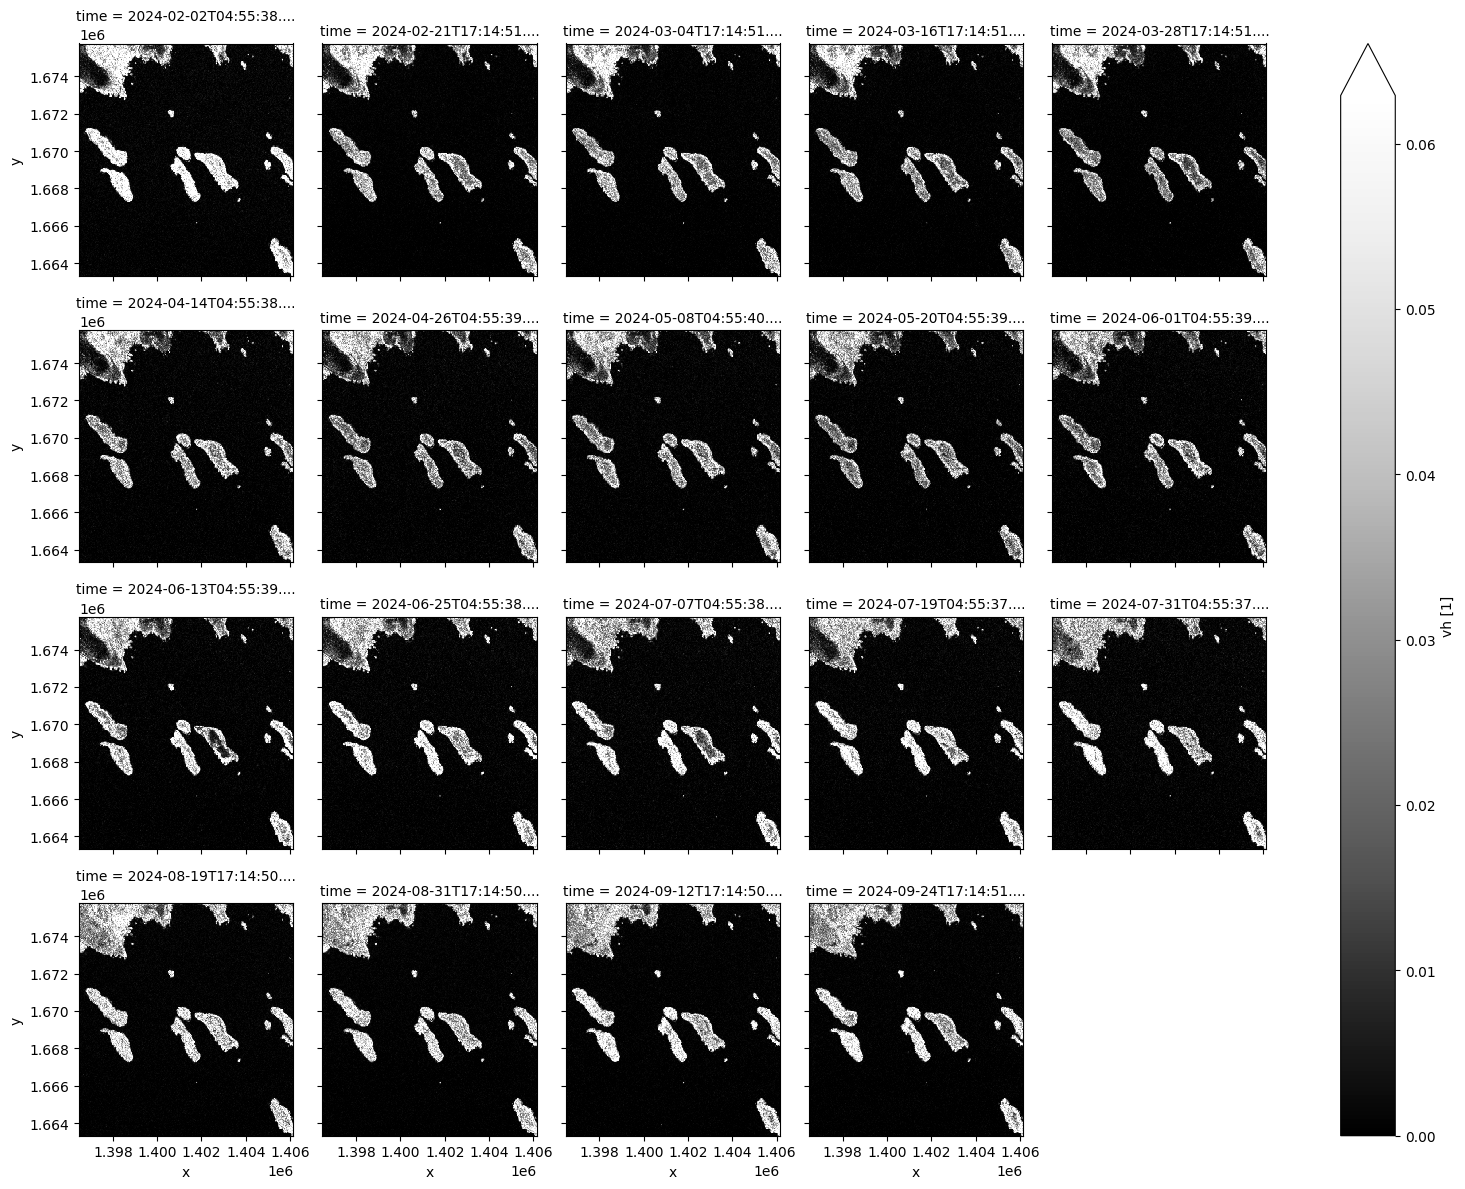

-21.168266


<Figure size 640x480 with 0 Axes>

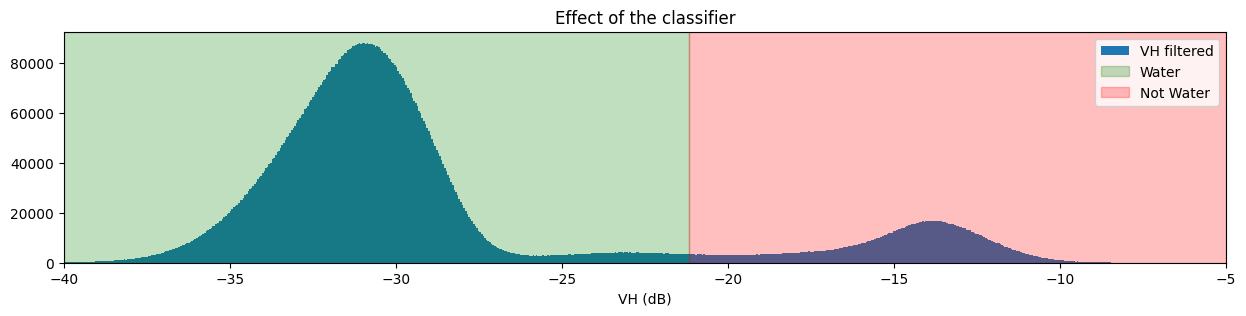



PROCESSING GRID CELL ID 2 NO. 2/2 CENTROID (13.30037, 14.52348)
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 38 time steps
38


<Figure size 640x480 with 0 Axes>

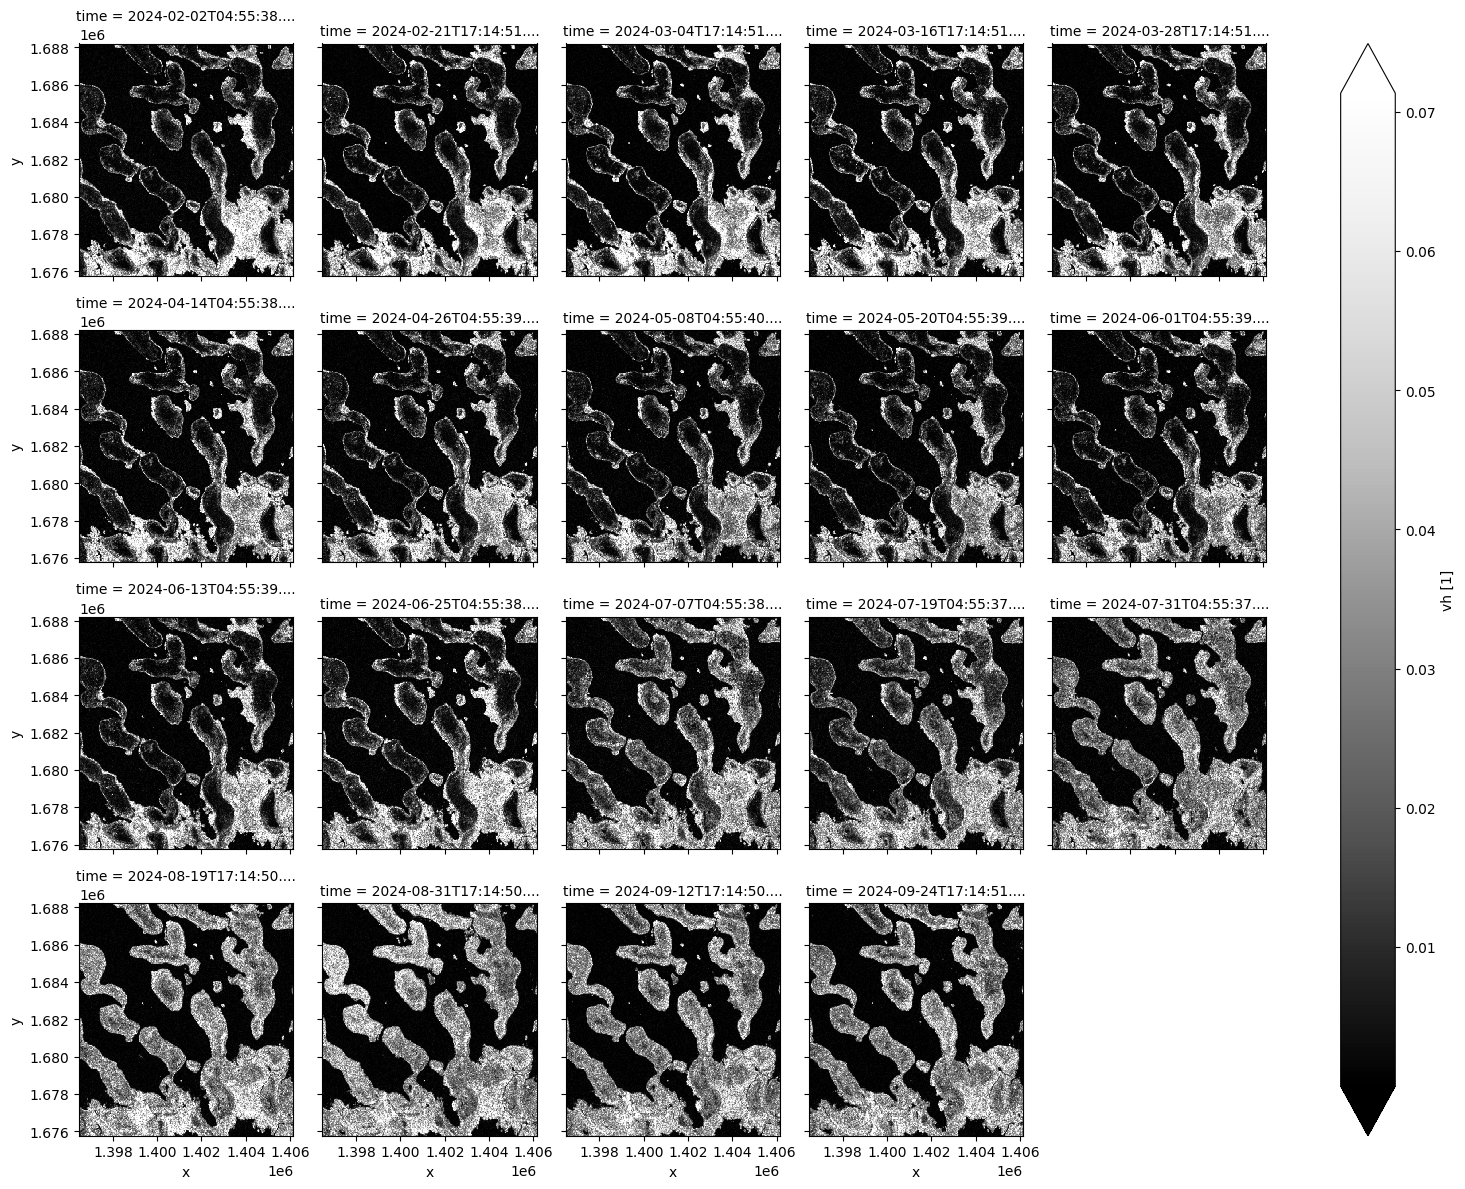

-25.72113


<Figure size 640x480 with 0 Axes>

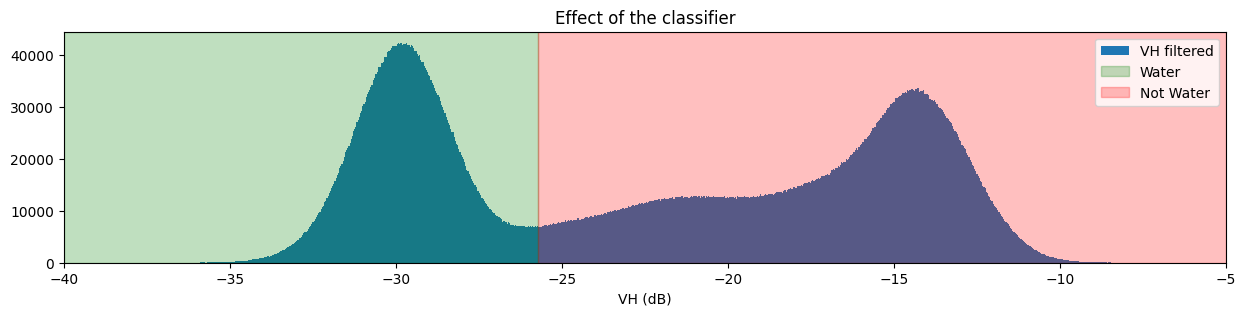



GRID PROCESSED AND UPLOADED SUCCESSFULLY


0


In [18]:
# Calls the checklist function
report = FPDF()
report.set_font("Helvetica", size=9)
exec_checks()

In [19]:
th_mean = round(statistics.fmean(th_aoi), 6)
th_median = round(statistics.median(th_aoi), 6)

report.add_page()
report.multi_cell(0, 10, "Mean Threshold: {}".format(th_mean))
report.multi_cell(0, 10, "Median Threshold: {}".format(th_median))

report.output("output/plots/th_report.pdf")

''

In [20]:
del_files("output/plots", "*")

Found 6 files. Deleting...


True

In [ ]:
e_log

In [ ]:
# Write error log to disc
e_log = np.array(e_log)
with open("error_centroids.json", "w") as filehandle:
    json.dump(e_log.tolist(), filehandle)

# read error log from disk
with open("error_centroids.json") as f:
    e_log = json.load(f)
for e in e_log:
    e[0] = float(e[0])
    e[1] = float(e[1])
    e[2] = int(e[2])

try:
    gd.upload_files(["error_centroids.json"], ERR_FOLDER_ID, False)
except Exception as e:
    print("FAILED TO UPLOAD ERROR LOG FILE REASON:{}".format(e))

e_log

In [ ]:
# Visualize Error Cells
e_grid = gpd.GeoDataFrame()
for e in e_log:
    point = Point(e[0], e[1])  # This takes x first and then y
    gdf = gpd.GeoDataFrame(geometry=[point])
    buffer = 0.25
    cell = gpd.GeoDataFrame()
    cell["geometry"] = gdf.buffer(buffer, cap_style="square")
    e_grid = pd.concat([e_grid, cell])
e_grid = e_grid.set_crs("epsg:4326")  # e_grid with same cell size as main grid

# e_grid_aoi = e_grid.dissolve()
# e_grid_fine = create_grid(e_grid_aoi, size) # if require to change the size and make it finer

view_input([e_grid], e_log)

In [ ]:
# Re-run application for cells logged in e_log
if len(e_log) > 0:
    e_log = gen_aoim(e_log, size / 2)